<a href="https://colab.research.google.com/github/IPMoroz/data_science/blob/main/%22ML_7_practice_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [46]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

%matplotlib inline
plt.style.use('seaborn')

# Подгрузка данных

In [ ]:
# подключаем google диск, где у нас хранятся данные
from google.colab import drive
drive.mount('/content/drive')
# # берем необходимый нам файл с диска, указав путь
df = pd.read_csv('./drive/MyDrive/_train_sem09.csv', sep = ',')
df.head()

In [47]:
df = pd.read_csv('https://lms.skillfactory.ru/assets/courseware/v1/9f2add5bca59f8c4df927432d605fff3/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/_train_sem09__1_.zip', sep=',')
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


## Проверим соотношение целевого признака

In [ ]:
df['Activity'].value_counts(normalize=True)

1    0.542255
0    0.457745
Name: Activity, dtype: float64

### целевой признак сбалансирован, но при разделении выборок можно использовать стратификацию

# Создаем матрицу наблюдений и вектор ответов (X, y)
# Разделяем выборку на тестовую и тренировочную

In [48]:
X = df.drop(['Activity'], axis=1)
y = df['Activity']
# для сохранения соотношения целевого признака используем stratify, random_state - 13
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=13, test_size=0.2)

# Обучаем модель логистической регрессии

In [ ]:
log_reg = linear_model.LogisticRegression(max_iter=1000, random_state=13)

log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе (lr): {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе (lr): {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе (lr): 0.79
f1_score на тестовом наборе (lr): 0.81


# Применим поиск гиперпараметров по сетке с кросс-валидацией Grid search на модели LogisticRegression

In [ ]:
param_grid = {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'saga'], # алгоритм оптимизации
               'C': [0.1, 0.2, 0.3, 0.4, 0.5]} # уровень силы регуляризаци

grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=13, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)

%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: user 14.6 s, sys: 1.8 s, total: 16.4 s
Wall time: 29min 56s
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs'}


Поиск занял 29 минут 56 секунд, на 20 вариантах набора гиперпараметров. 
При значениях 'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs' метрика accuracy равна 0,79, а f1 - 0,81

## Визуализируем

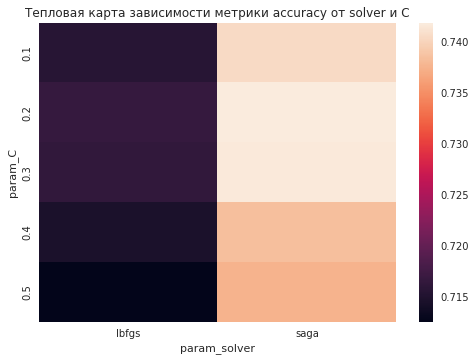

In [ ]:
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и C')
sns.set(rc={'figure.figsize':(12,8)})

# Попробуем подобрать гиперпараметры при помощи RandomSearch, оставив значения penalty и solver и расширив диапазон C.

In [ ]:
param_distributions = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'newton-cg'], # алгоритм оптимизации
               'C': list(np.linspace(0.1, 0.3, 10, dtype=float))}, # уровень силы регуляризации
]
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=13, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10,
    error_score='raise',
    n_jobs = -1
)  
 
 
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: user 10.6 s, sys: 1.43 s, total: 12.1 s
Wall time: 11min 46s
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.2111111111111111}


Получены такие же метрики, как и при GreadSearch. Однако времени затрачено в 3 раза меньше. Заметно что solver в этот раз - newton-cg.

# Используем продвинутую оптимизацию Hyperopt

In [ ]:
space = {'penalty': hp.choice('penalty', ['l2', 'l1']),
    'solver' : hp.choice('solver', ['liblinear', 'saga']),
    'C': hp.uniform('C', 0.01, 0.5)
    }

random_state = 13
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 'solver': params['solver'], 'C': float(params['C'])}
# используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, max_iter=1000, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs
 10%|█         | 2/20 [03:31<31:51, 106.21s/it, best loss: -0.7782412727931433]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



 20%|██        | 4/20 [10:34<40:30, 151.91s/it, best loss: -0.7809899550187176]  

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



 25%|██▌       | 5/20 [17:39<1:02:33, 250.24s/it, best loss: -0.7809899550187176]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



 40%|████      | 8/20 [23:00<25:15, 126.26s/it, best loss: -0.7809899550187176]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



 55%|█████▌    | 11/20 [31:59<21:00, 140.08s/it, best loss: -0.7809899550187176]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



 65%|██████▌   | 13/20 [38:46<18:00, 154.40s/it, best loss: -0.7809899550187176]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



 70%|███████   | 14/20 [45:48<23:31, 235.22s/it, best loss: -0.7809899550187176]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



 75%|███████▌  | 15/20 [51:58<22:58, 275.63s/it, best loss: -0.7809899550187176]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



100%|██████████| 20/20 [1:00:32<00:00, 181.63s/it, best loss: -0.7809899550187176]
Наилучшие значения гиперпараметров {'C': 0.23682792088234034, 'penalty': 1, 'solver': 0}


Можно продолжить подбор, но большого смысла в этом на мой взгляд нет. Лучшая метрика получена на 4 итерации и далее не улучшиласть. Визуализируем.

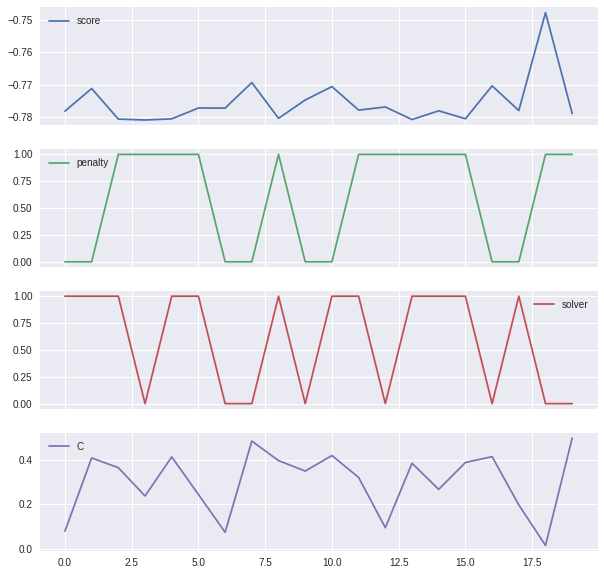

In [ ]:
tpe_results=np.array([[x['result']['loss'], x['misc']['vals']['penalty'][0], x['misc']['vals']['solver'][0], x['misc']['vals']['C'][0]] for x in trials.trials])
tpe_results_df=pd.DataFrame(tpe_results, columns=['score', 'penalty', 'solver', 'C'])
tpe_results_df.plot(subplots=True, figsize=(10, 10));

In [ ]:
# hyperopt вывел значения параметров в виде их индексов 'penalty': 1, 'solver': 0
# для построения модели создадим словари
pty = {0:'l2', 1:'l1'}
sver = {0:'liblinear', 1:'saga'}

In [ ]:
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=pty[best['penalty']], 
    solver=sver[best['solver']],
    C=float(best['C'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.83
accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80


Значение accuracy на тестовом наборе осталось на прежнем уровне, метрику f1 улучшить не получилось. Времени при этом затрачено в 2 раза больше чем в GreedSearch и в 6 раз больше чем в RandomSearch

# Продвинутая подборка Optuna для модели Logistic Regression

In [50]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def optuna_lr(trial):
  penalty=trial.suggest_categorical('penalty', ['l2','none'])
  solver=trial.suggest_categorical('solver', ['lbfgs', 'saga'])
  C=trial.suggest_float('C', 0.01, 1, step=0.01, log=False)

  model=linear_model.LogisticRegression(penalty=penalty,
                                        solver=solver,
                                        C=C,
                                        max_iter=1000,
                                        random_state=13)
  
  model.fit(X_train, y_train)
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [ ]:
import optuna
%time
study=optuna.create_study(study_name="LogisticRegression", direction='maximize')
study.optimize(optuna_lr, n_trials=50)

print('Лучшие параметры: {}'.format(study.best_params))
print('Лучшее значение метрики: {}'.format(study.best_value))

[I 2022-10-17 15:41:17,917] A new study created in memory with name: LogisticRegression


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


[I 2022-10-17 15:43:24,056] Trial 0 finished with value: 0.7807266544149869 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.2}. Best is trial 0 with value: 0.7807266544149869.
[I 2022-10-17 15:47:02,321] Trial 1 finished with value: 0.7771744045455328 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.75}. Best is trial 0 with value: 0.7807266544149869.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

Лучшие параметры: {'penalty': 'l2', 'solver': 'saga', 'C': 0.04}
Лучшее значение метрики: 0.7897124883823335


In [ ]:
model=linear_model.LogisticRegression(**study.best_params, max_iter=10000, random_state=13)
model.fit(X_train, y_train)
y_train_pred=model.predict(X_train)
print('Значение accuracy на тестовом наборе:{}'.format(model.score(X_test, y_test)))
y_test_pred=model.predict(X_test)
print('Значение f1_score на тестовом наборе:{}'.format(metrics.f1_score(y_test, y_test_pred)))

Значение accuracy на тестовом наборе:0.7816245006657789
Значение f1_score на тестовом наборе:0.803357314148681


За 50 итераций улучшения метрики не достигнуто.
Попробуем визуализировать

In [ ]:
optuna.visualization.is_available()

True

In [ ]:
optuna.visualization.plot_optimization_history(
    study, target_name="f1_score"
)

Лучший результат получент на 12 итерации

In [ ]:
optuna.visualization.plot_param_importances(
    study, target_name="f1_score"
)

Максимальное влияние на метрику оказывает параметр 'penalty'

In [ ]:
optuna.visualization.plot_contour(
    study, params=["penalty","solver"],
    target_name='f1_score'
)

# Проведем такие же подборы гиперпараметров на ансамбле RandomForest

In [ ]:
rnd_fst = ensemble.RandomForestClassifier(
    criterion='entropy', #критерий эффективности
    random_state=13
    )

#Обучаем модель
rnd_fst.fit(X_train, y_train)
print("accuracy на тестовом наборе (rf): {:.2f}".format(rnd_fst.score(X_test, y_test)))
y_test_pred = rnd_fst.predict(X_test)
print('f1_score на тестовом наборе (rf): {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе (rf): 0.84
f1_score на тестовом наборе (rf): 0.85


Результат превзошел логистическую регрессию, 0.85 больше 0.81

#GreedSearch на модели Random Forest

In [ ]:
param_grid = [{'max_depth': [5,10,15,20,25],
               'min_samples_leaf': [2,3,4,5,6,7,8,9],
               'n_estimators': [100, 200, 300, 400, 500]}
              ]

grid_search = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(
        criterion='entropy', #критерий эффективности
        random_state=13
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)

%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: user 27.5 s, sys: 2.27 s, total: 29.8 s
Wall time: 46min 48s
accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.84
Наилучшие значения гиперпараметров: {'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 300}


Подбор занял 47 минут, но метрику улучшить не удалось

# RandomSearch на модели RandomForest

In [ ]:
param_distributions = {'min_samples_leaf': list(np.linspace(1, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'n_estimators': list(np.linspace(100, 500, 50, dtype=int))
              }
            
random_search_tree = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(criterion='entropy', random_state=13), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_tree.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test, y_test)))
y_test_pred = random_search_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

CPU times: user 6.86 s, sys: 475 ms, total: 7.33 s
Wall time: 7min 5s
accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.84
Наилучшие значения гиперпараметров: {'n_estimators': 173, 'min_samples_leaf': 3, 'max_depth': 14}


За 7 минут удалось получить тот же результат что и при GS, но с другими параметрами

# Hyperopt RandomForest

In [ ]:
space = {'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
    'max_depth': hp.quniform('max_depth', 1, 30, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)    }

random_state = 13
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 'max_depth': int(params['max_depth']), 'min_samples_leaf': int(params['min_samples_leaf'])}
# используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 16 µs
100%|██████████| 20/20 [05:24<00:00, 16.24s/it, best loss: -0.8108575555084491]
Наилучшие значения гиперпараметров {'max_depth': 23.0, 'min_samples_leaf': 4.0, 'n_estimators': 107.0}


Попробуем продолжить подбор

In [ ]:
best=fmin(hyperopt_rf, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=np.random.RandomState(random_state))
print("Наилучшие значения гп{}".format(best))

100%|██████████| 30/30 [07:07<00:00, 14.24s/it, best loss: -0.8147971554775992]
Наилучшие значения гп{'max_depth': 27.0, 'min_samples_leaf': 4.0, 'n_estimators': 103.0}


In [ ]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.96
accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.84


Подборка гиперпараметров Hyperopt за 50 итераций не смогла улучшить результат двух предыдущих подборов

Визуализация

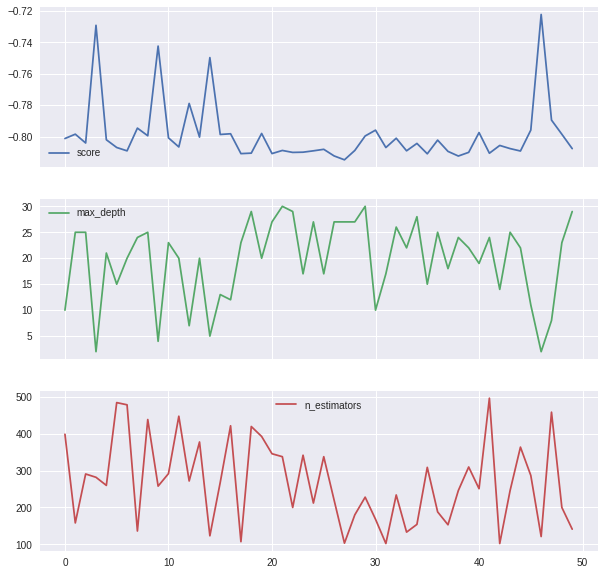

In [ ]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

# Подберем параметры при помощи Optuna, кроссвалидацию установим из 5 фолдов

In [52]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 600, 50)
  max_depth = trial.suggest_int('max_depth', 1, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score
  
random_state = 42

In [53]:
import optuna
%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=40)

[I 2022-10-28 09:19:48,590] A new study created in memory with name: RandomForestClassifier


CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 13.6 µs


[I 2022-10-28 09:20:08,975] Trial 0 finished with value: 0.8046648651393136 and parameters: {'n_estimators': 300, 'max_depth': 39, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8046648651393136.
[I 2022-10-28 09:20:20,521] Trial 1 finished with value: 0.7957629868110592 and parameters: {'n_estimators': 200, 'max_depth': 21, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.8046648651393136.
[I 2022-10-28 09:20:27,801] Trial 2 finished with value: 0.731593853978213 and parameters: {'n_estimators': 400, 'max_depth': 2, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8046648651393136.
[I 2022-10-28 09:20:49,063] Trial 3 finished with value: 0.8149607563618684 and parameters: {'n_estimators': 250, 'max_depth': 38, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.8149607563618684.
[I 2022-10-28 09:21:18,115] Trial 4 finished with value: 0.8018846330776309 and parameters: {'n_estimators': 500, 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.81496

In [54]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 350, 'max_depth': 38, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.82


Лучшие параметры подобраны только на 40 итерации


In [55]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на обучающем наборе: {:.2f}".format(model.score(X_train, y_train)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.84


Запустим еще 10 итераций

In [56]:
%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.5 µs


[I 2022-10-28 09:40:06,430] Trial 40 finished with value: 0.8033424676139298 and parameters: {'n_estimators': 350, 'max_depth': 38, 'min_samples_leaf': 7}. Best is trial 39 with value: 0.8178762115126039.
[I 2022-10-28 09:40:26,140] Trial 41 finished with value: 0.8177761172362151 and parameters: {'n_estimators': 250, 'max_depth': 33, 'min_samples_leaf': 2}. Best is trial 39 with value: 0.8178762115126039.
[I 2022-10-28 09:40:47,477] Trial 42 finished with value: 0.8179758617765804 and parameters: {'n_estimators': 250, 'max_depth': 39, 'min_samples_leaf': 2}. Best is trial 42 with value: 0.8179758617765804.
[I 2022-10-28 09:41:06,110] Trial 43 finished with value: 0.8140309741133296 and parameters: {'n_estimators': 250, 'max_depth': 39, 'min_samples_leaf': 3}. Best is trial 42 with value: 0.8179758617765804.
[I 2022-10-28 09:41:27,518] Trial 44 finished with value: 0.815176189553747 and parameters: {'n_estimators': 250, 'max_depth': 33, 'min_samples_leaf': 1}. Best is trial 42 with val

In [57]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на обучающем наборе: {:.2f}".format(model.score(X_train, y_train)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.84


Метрики не улучшились, однако accuracy на обучающем наборе близко к 1 что может говорить о переобученности модели

In [58]:
optuna.visualization.is_available()

True

In [59]:
optuna.visualization.plot_optimization_history(
    study, target_name="f1_score"
)

In [60]:
optuna.visualization.plot_param_importances(
    study, target_name="f1_score"
)

In [64]:
optuna.visualization.plot_contour(
    study, params=["max_depth","min_samples_leaf", "n_estimators"],
    target_name='f1_score'
)

#Можно сделать следующие выводы:


1.   Построение моделей на гиперпараметрах по умолчанию показывает лучшие результаты метрик (применительно данного датафрейма)
2.   Ни один из использованных методов подбора не выдал результата метрики f1_score больше "дефолтного"
3.   Метрика accuracy стремится к единице, что может свидетельствовать о переобученности моделей

PS: Если можно, подробную обратную связь. Что правильно, что неправильно и как сделать чтобы было правильно. Осталось очень много вопросов, ответы на которые не находятся в материалах курса.
